# Lab N
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [26]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(434, 500)


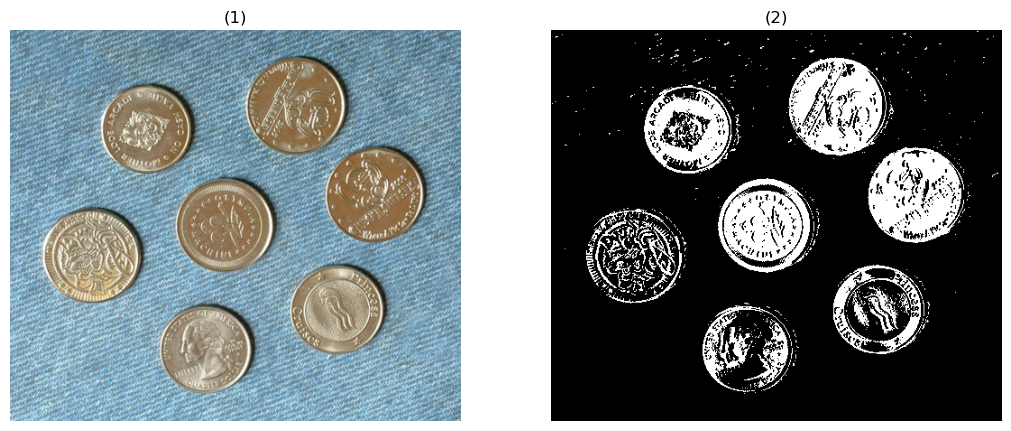

In [27]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''
img = io.imread('./img/coins.jpg')
target_rgb = (133, 110, 79)
binaried = np.zeros(img.shape[0:2])
print(binaried.shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        r = img[i][j][0]
        g = img[i][j][1]
        b = img[i][j][2]
        dist = np.sqrt((target_rgb[0] - r )**2 + (target_rgb[1] - g )**2 + (target_rgb[2] - b )**2)
        if(dist < 60):
            binaried[i][j] = 1.0
            
show_images([img,binaried])



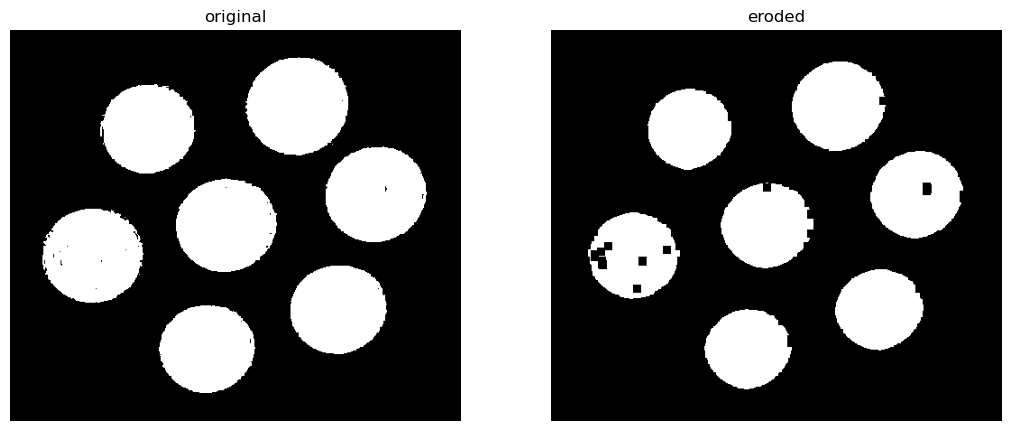

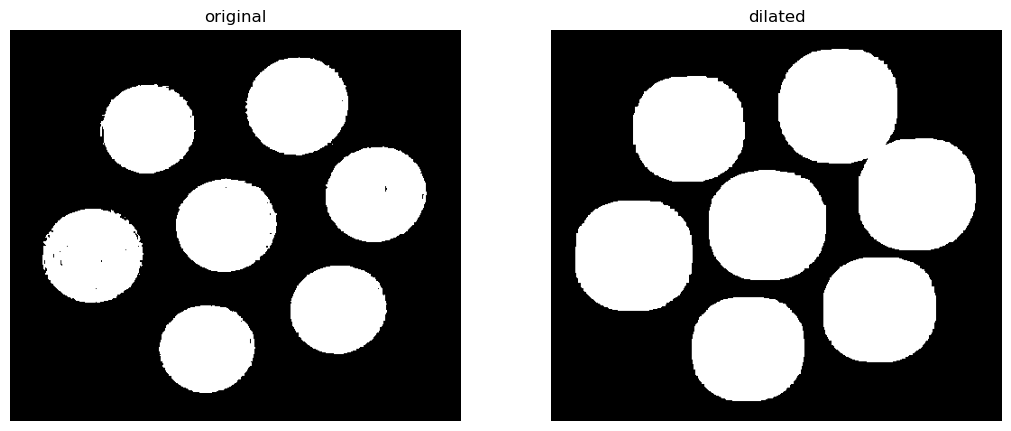

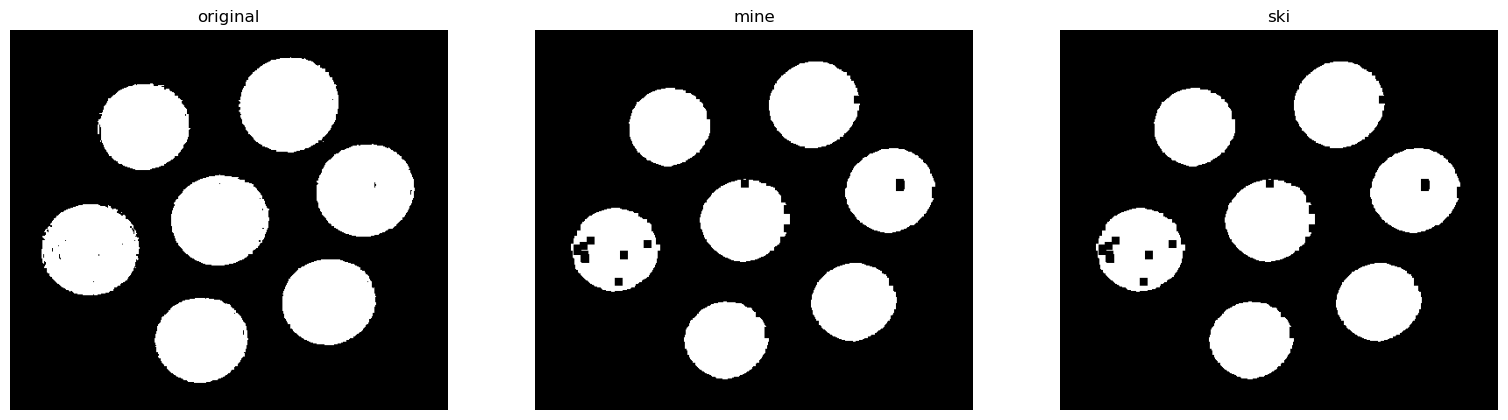

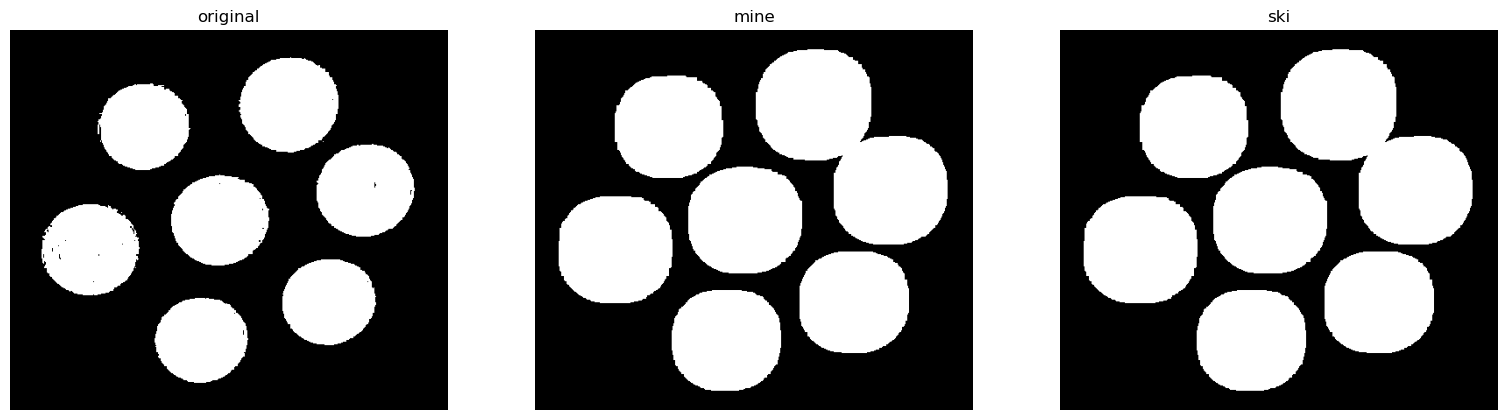

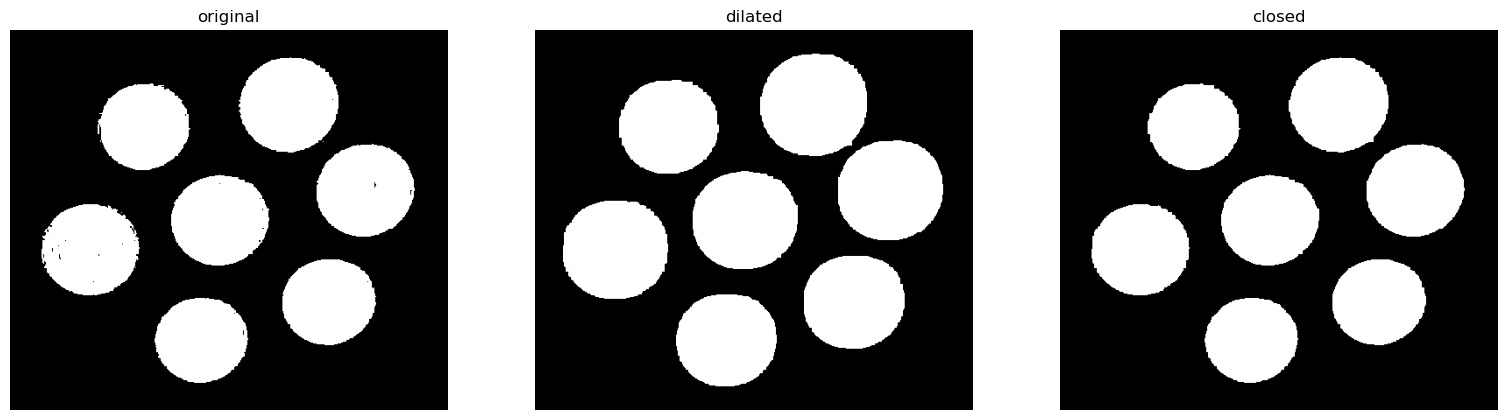

In [34]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results

'''


def erode(binary_img, window_size):
    '''window size should be odd'''
    # check if window size is array
    if(type(window_size) == int):
        window_size = (window_size, window_size)
    
    se = np.ones(window_size)
    eroded = np.zeros(binary_img.shape)
    
    # sliding window over the image 
    for i in range(binary_img.shape[0] - window_size[0] + 1):
        for j in range(binary_img.shape[1] - window_size[1] + 1):
            # check if any pixel in the window is 0
            wind = binary_img[i:i+window_size[0], j:j+window_size[1]]
            eroded[i+int(window_size[0]/2)][j+int(window_size[1]/2)] = np.min(wind)
                
    return eroded

def dilate(binary_img, window_size):
    '''window size should be odd'''
    if(type(window_size) == int):
        window_size = (window_size, window_size)
    se = np.ones(window_size)
    dilated = np.zeros(binary_img.shape)
    
    for i in range(binary_img.shape[0] - window_size[0] + 1):
        for j in range(binary_img.shape[1] - window_size[1] + 1):
            
            wind = binary_img[i:i+window_size[0], j:j+window_size[1]]
            dilated[i+int(window_size[0]/2)][j+int(window_size[1]/2)] = np.max(wind)
            
    return dilated


img = io.imread('./img/coins.jpg')

# see the hsv image
hue = (rgb2hsv(img)[:,:,0] * 255).astype(np.uint8)

thres = 100
hue[hue < thres] = 1
hue[hue >= thres] = 0

a = erode(hue, 9)
show_images( [hue, a],['original','eroded'])
b = dilate(hue, 19)
show_images([hue, b],['original','dilated'])

ret = binary_erosion(hue, footprint=np.ones((9,9)))
show_images([hue, a,ret],['original','mine','ski'])

ret2 = binary_dilation(hue, footprint=np.ones((19,19)))
show_images([hue, b,ret2],['original','mine','ski'])


ret3 = binary_closing(hue, footprint=np.ones((9,9)))
b = dilate(hue, 9)

show_images([hue, b,ret3],['original','dilated','closed'])



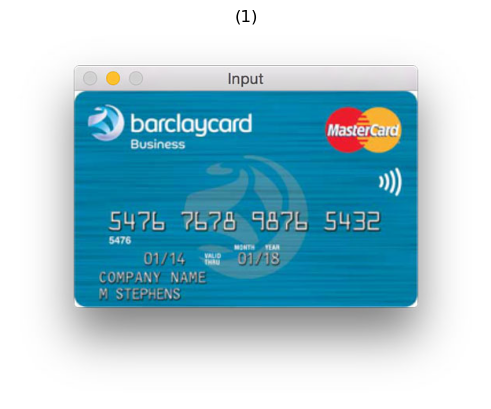

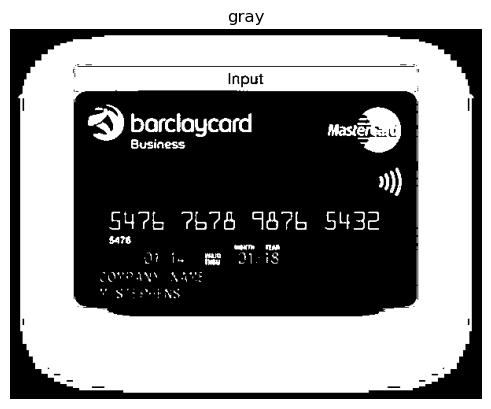

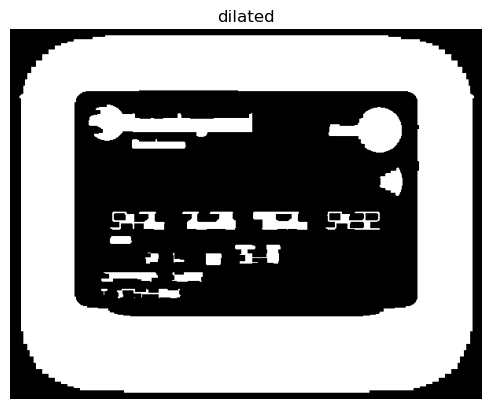

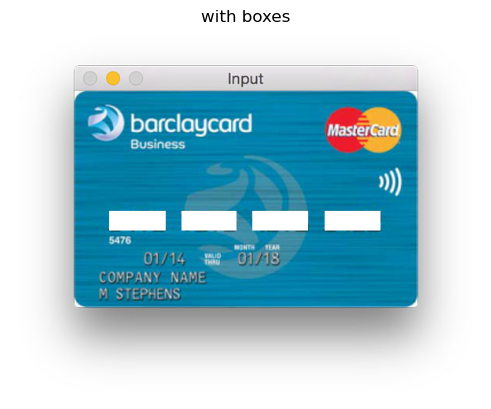

In [29]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''
img = io.imread('./img/card.jpg')
show_images([img])
img_with_boxes = img.copy()
img_gray = (rgb2gray(img) * 256).astype(np.uint8)

img_gray[img_gray < 0.6 * 256] = 0
img_gray[img_gray >= 0.6 * 256] = 255

show_images([img_gray],['gray'])
img_gray = dilate(img_gray,(5,12))
img_gray = erode(img_gray,(5,12))



show_images([img_gray],['dilated'])

contours = find_contours(img_gray, 0.8)
bounding_boxes = []
for contour in contours:
    Ymax = np.max(contour[:,0])
    Ymin = np.min(contour[:,0])
    Xmax = np.max(contour[:,1])
    Xmin = np.min(contour[:,1])
    aspect = (Xmax - Xmin) / (Ymax - Ymin) 
    height = Ymax - Ymin
    if(2.5 < aspect  < 3.5 and height > 20):
        bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])

#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img_gray.shape)
    rr = rr.astype(int)
    cc = cc.astype(int)
    img_with_boxes[rr, cc] = 255 #set color white
    
show_images([img_with_boxes],['with boxes'])

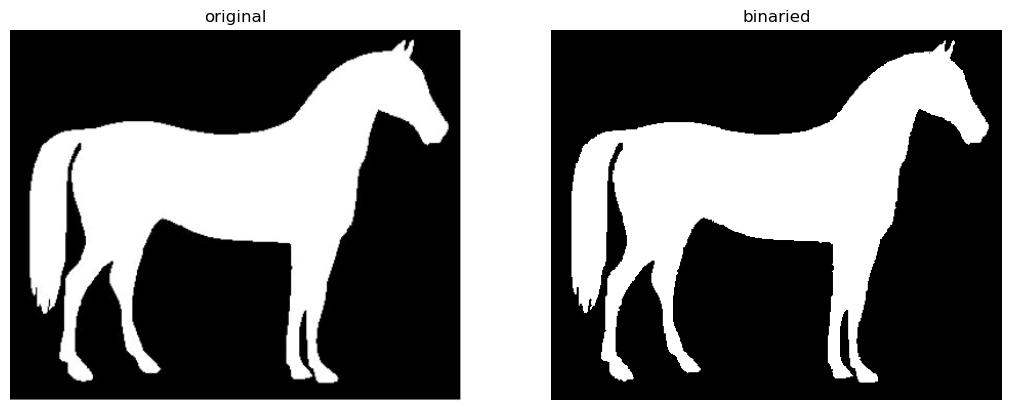

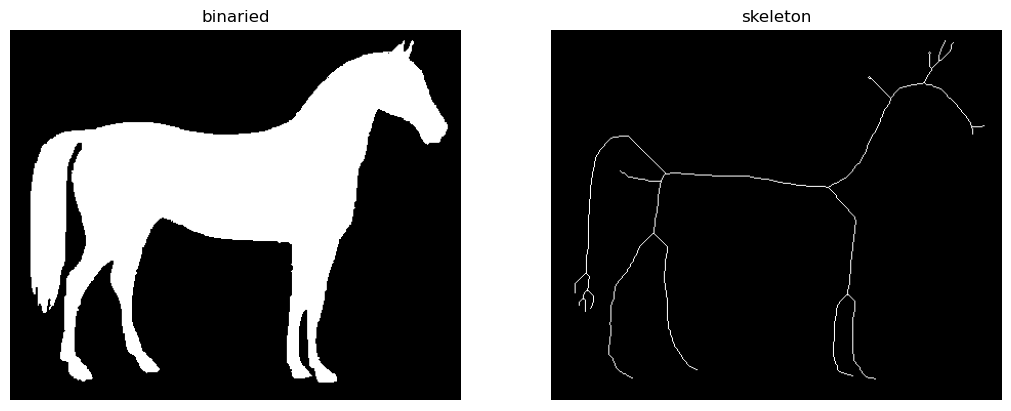

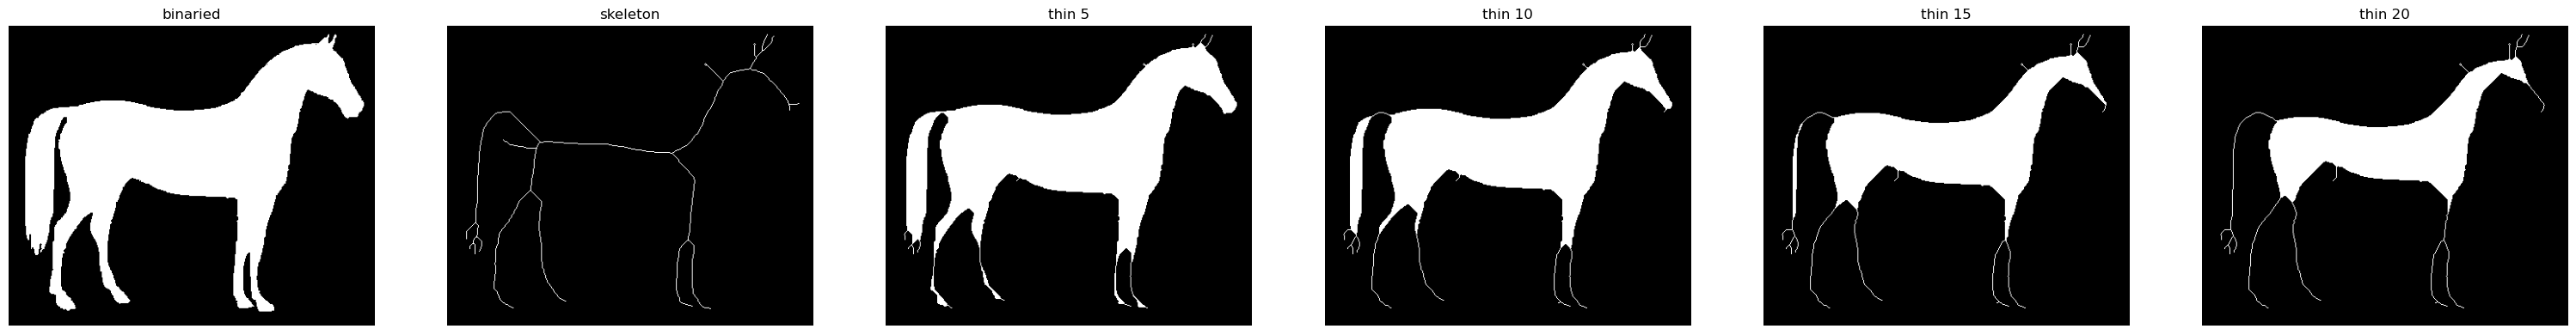

In [30]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''
img = io.imread('./img/horse.jpg', as_gray=True)
binaried = img.copy()
binaried[binaried < 0.9] = 0
binaried[binaried >= 0.9] = 1
show_images([img, binaried],['original','binaried'])
skel = skeletonize(binaried)
show_images([binaried, skel],['binaried','skeleton'])

thins = []
values = [5,10,15,20]
for i in values:
    thins.append(thin(binaried, max_num_iter=i))
show_images([binaried, skel, thins[0], thins[1], thins[2], thins[3]],['binaried','skeleton','thin 5','thin 10','thin 15','thin 20'])